## Exercise 5: Logistic Regression and Causal Inference

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt

### Task 1: Logistic Regression

Again, we revisit the Student Performance dataset. This time however, we do not focus on predicting test performance, but on predicting whether a student has taken the test preparation course.

#### a) Fitting and model analysis

Preprocess the data like in the previous exercise, i.e. transform categorical variables and remove highly correlated predictors. Then, fit a logistic regression model with statsmodels, that aims to predict the completion of a test preparation course model. Which predictors appear significant?

In [2]:
df = pd.read_csv("StudentsPerformance.csv")

print(np.where(df.iloc[:,1:].corr() > 0.8))
# writing and reading are highly correlated!
df = df.drop("reading score", axis = 1)
df.head()

(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2]))


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,69,88
2,female,group B,master's degree,standard,none,90,93
3,male,group A,associate's degree,free/reduced,none,47,44
4,male,group C,some college,standard,none,76,75


In [3]:
# transform categorical to multiple dummies variables (drop one category to avoid collinearities)
X = pd.get_dummies(df[df.columns.difference(["test preparation course"])], drop_first = True)

X = sm.add_constant(X)
y = np.where(df["test preparation course"].str.contains("none"), 0, 1)

# fit model - note shorter syntax
results = sm.Logit(y, X).fit()

# print summary
results.summary()

Optimization terminated successfully.
         Current function value: 0.519176
         Iterations 6


C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      986
Method:                           MLE   Df Model:                           13
Date:                Fri, 15 Nov 2019   Pseudo R-squ.:                  0.2040
Time:                        12:28:02   Log-Likelihood:                -519.18
converged:                       True   LL-Null:                       -652.26
Covariance Type:            nonrobust   LLR p-value:                 2.783e-49
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -6.5128      0.602    -10.819      0.000      -7.693      -5.333
math score                                       -0.1408      0.015     -9.562      0.000      -0.170      -0.112
writing score                                     0.2029      0.016     12.476      0.000       0.171       0.235
gender_male                                       2.5808      0.264      9.774      0.000       2.063       3.098
lunch_standard                                   -0.2120      0.173     -1.229      0.219      -0.550       0.126
parental level of education_bachelor's degree    -0.3618      0.271     -1.334      0.182      -0.893       0.170
parental level of education_high school           0.1344      0.244      0.552      0.581      -0.343       0.612
parental level of education_master's degree      -0.7112      0.355     -2.005      0.045      -1.406      -0.016
parental level of education_some college         -0.0260      0.227     -0.114      0.909      -0.471       0.419
parental level of education_some high school      0.7492      0.243      3.084      0.002       0.273       1.225
race/ethnicity_group B                            0.2198      0.316      0.694      0.487      -0.401       0.840
race/ethnicity_group C                            0.0452      0.294      0.154      0.878      -0.532       0.622
race/ethnicity_group D                           -0.5261      0.305     -1.725      0.085      -1.124       0.072
race/ethnicity_group E                            0.8554      0.340      2.519      0.012       0.190       1.521
=================================================================================================================
"""

#### b) Diagnostics 1: Accuracy and Confusion Matrix

Write a two function that take as input a vector y of the true classes, and a vector y_hat of the predicted classes. Let the first one return the accuracy of the prediction, i.e. the ratio of correctly predicted samples, and the second one compute the confusion matrix as introduced in class.
Apply your function on your model from a).

In [4]:
def accuracy(y,y_hat):
    return sum(y==y_hat)*1.0/len(y)

y_hat = (results.predict(X) >= 0.5).astype(int)
print(accuracy(y,y_hat))

0.742


In [5]:
def confusion_matrix(y,y_hat):
    CM = np.zeros((2,2))
    for i in range(len(y)):
        CM[y_hat[i],y[i]] +=1
    return CM

y_hat = (results.predict(X) >= 0.5).astype(int)
print(confusion_matrix(y,y_hat))

[[549. 165.]
 [ 93. 193.]]


#### c) Diagnostics 2: The ROC curve

Write a function that takes as input a vector y of the true classes, and a vector yp of the predicted probabilities resulting from the logistic regression, plots the ROC curve of the model, and returns the corresponding AUC score.
Apply your function on your model from a).

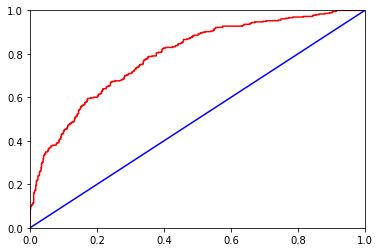

0.6877988826815642

In [7]:
from matplotlib import pyplot as plt

def ROC(y, yp):
    n = len(y)
    thresholds = np.sort(yp)
    TPR, FPR = np.zeros(n),np.zeros(n)
    for i in range(n):
        CM = confusion_matrix(y,(yp>=thresholds[i]).astype(int))
        FPR[i], TPR[i] = CM[1,0]/np.sum(CM[:,0]), CM[1,1]/np.sum(CM[:,1])
        
    plt.plot(FPR,TPR, color = "red")
    plt.plot([0,1],[0,1], color = "blue")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()
    
    return (np.sum(TPR)/n)
    
ROC(y, results.predict(X))

### Task 2: Causal Inference

In this task we use a dataset (NSW.csv) which aimed to evaluate the effect of participating in a job training program on the salary. This data was taken from the website of Gelman and Hill's book (http://www.stat.columbia.edu/~gelman/arm/), and originally constructed in two independent studies (see Gelman and Hill, chapter 10, ex. 1).
This data contains some demographic data of its population, the real earnings in 1974 and 1975, and indicator on whether job training, i.e., the treatment, was conducted in 1976/77, and the earnings in 1978, which is our target variable. A brief documentation can be found in "NSW.doc". Make sure that when loading the data, you omit the sample variable which simply indicates a source that a specific obervation originated from.  
Note that there are only very few treated individuals in the dataset.

In [3]:
df = pd.read_csv("NSW.csv", index_col=0)

print(df.head())
print(df.shape)
df.treat.sum() #only 185 out of 18667 individuals received treatment

   age  educ  black  married  nodegree          re74          re75  \
1   42    16      0        1         0      0.000000      0.000000   
2   20    13      0        0         0   2366.794189   3317.467773   
3   37    12      0        1         0  25862.322266  22781.855469   
4   48    12      0        1         0  21591.121094  20839.355469   
5   51    12      0        1         0  21395.193359  21575.177734   

           re78  hisp  sample  treat  educ_cat4  
1    100.485405     0       2      0          4  
2   4793.745117     0       2      0          3  
3  25564.669922     0       2      0          2  
4  20550.744141     0       2      0          2  
5  22783.587891     0       2      0          2  
(18667, 12)


185

#### a) Mean and Regression analysis with one predictor

We first simply consider the treatment as a predictor for the earnings in 1978. 
Investigate the effect of the treatment by (i) computing the difference in means between control and treatment groups and (ii) performing a linear regression with only one predictor.
What do you observe?

In [4]:
mean_tr = np.mean(df.loc[df.treat == 1,"re78"])
mean_co = np.mean(df.loc[df.treat == 0,"re78"])
print(mean_tr)
print(mean_co)

6349.143502065298
15750.299950189565


In [9]:
X1 = sm.add_constant(df.treat)
y = df.re78

reg1 = sm.OLS(y, X1).fit()

reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     137.4
Date:                Mon, 25 Nov 2019   Prob (F-statistic):           1.26e-31
Time:                        14:07:24   Log-Likelihood:            -1.9995e+05
No. Observations:               18667   AIC:                         3.999e+05
Df Residuals:                   18665   BIC:                         3.999e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.575e+04     79.839    197.276      0.000    1.56e+04    1.59e+04
treat      -9401.1564    801.983    -11.722      0.000    -1.1e+04   -7829.197
==============================================================================
Omnibus:                     2413.767   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10003.121
Skew:                           0.591   Prob(JB):                         0.00
Kurtosis:                       6.386   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Answer:__ The mean income of the treated group appears to be much lower than the treatment of the non-treated group, and the regreesion seems to indicate that the treatment has a significant negative effect, which would not have been expected. However, we can not yet conclude that there indeed is such a negative effect, as there may be confounding variables.

#### b) Variable bias

Intuitively, it makes sense that the income in 1975 has strong predictive power in the earnings 3 years later. Recompute your regression model such that it additionally includes that income. 
Further, compute the omitted variable bias between the treatment and the income from 75.

In [30]:
pred_cols = ['treat','re75']
X2 = sm.add_constant(df[pred_cols])

reg2 = sm.OLS(y, X2).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     8829.
Date:                Fri, 15 Nov 2019   Prob (F-statistic):               0.00
Time:                        13:20:31   Log-Likelihood:            -1.9380e+05
No. Observations:               18667   AIC:                         3.876e+05
Df Residuals:                   18664   BIC:                         3.876e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5004.4734     99.693     50.199      0.000    4809.067    5199.880
treat        199.8030    581.584      0.344      0.731    -940.155    1339.761
re75           0.7473      0.006    131.883      0.000       0.736       0.758
==============================================================================
Omnibus:                     2962.729   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48376.792
Skew:                           0.218   Prob(JB):                         0.00
Kurtosis:                      10.874   Cond. No.                     1.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# Omitted variable bias:

# compute 3rd model that predicts confounder to compute omitted variable bias
X3 = sm.add_constant(df.treat)
yc = df.re75 # confounder as target variable
reg3 = sm.OLS(yc, X3).fit()

reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re75   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     297.1
Date:                Fri, 15 Nov 2019   Prob (F-statistic):           4.57e-66
Time:                        13:22:26   Log-Likelihood:            -1.9858e+05
No. Observations:               18667   AIC:                         3.972e+05
Df Residuals:                   18665   BIC:                         3.972e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.438e+04     74.204    193.791      0.000    1.42e+04    1.45e+04
treat      -1.285e+04    745.380    -17.237      0.000   -1.43e+04   -1.14e+04
==============================================================================
Omnibus:                     2296.456   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9908.732
Skew:                           0.546   Prob(JB):                         0.00
Kurtosis:                       6.398   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
beta1star = reg1.params[1]
beta1 = reg2.params[1]
beta2 = reg2.params[2]
gamma1 = reg3.params[1]

print([beta1star,beta1,beta2,gamma1])
print(beta1+beta2*gamma1)
print("omitted variable bias: " + str(beta2*gamma1))

[-9401.156448124559, 199.80298354370552, 0.7472752869446623, -12847.95523069307]
-9401.156448124631
omitted variable bias: -9600.959431668338


#### c) Adding more predictors

Our data provides a lot more potential predictors. Add some more predoctors to your regression model and observe the sensitivity of the model to new predictors.

In [48]:
pred_cols1 = ['age','black','hisp','married','educ','nodegree','re74','re75','treat']
X = df[pred_cols1]

results = sm.OLS(y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   re78   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                          1.097e+04
Date:                Fri, 15 Nov 2019   Prob (F-statistic):                        0.00
Time:                        13:31:24   Log-Likelihood:                     -1.9331e+05
No. Observations:               18667   AIC:                                  3.866e+05
Df Residuals:                   18658   BIC:                                  3.867e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          -86.7929      5.396    -16.086      0.000     -97.369     -76.217
black       -146.5119    189.494     -0.773      0.439    -517.937     224.913
hisp         282.7274    226.290      1.249      0.212    -160.822     726.277
married      288.6561    144.277      2.001      0.045       5.861     571.451
educ         505.4319     11.940     42.332      0.000     482.029     528.835
nodegree    1852.2940    131.511     14.085      0.000    1594.520    2110.068
re74           0.2966      0.011     26.611      0.000       0.275       0.319
re75           0.5117      0.011     45.920      0.000       0.490       0.534
treat        695.4787    584.717      1.189      0.234    -450.621    1841.578
==============================================================================
Omnibus:                     2838.034   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47844.023
Skew:                           0.095   Prob(JB):                         0.00
Kurtosis:                      10.841   Cond. No.                     2.61e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Answer:__ We observe many additional confounding effect, e.g. both ecuation related predictors induce strong omitted-variable biases on the treatment. After adding all variables, we still obtain a high treatment coefficient of 600, however we do not really have a strong confidence in it anymore, and the lower boundary of the 95% confidence interval is actually negative.

#### c) Greedy matching

We now consider ALL columns in the data as predictors. Due to the numerical imbalance in the data, we have many samples that we would not want to include in our analysis with the treatment group.  
Implement a function that is given as input two matrices corresponding to the confounders of controal and treatment group, and returns a matching of their indices based on Mahalanobis distance.
Apply your function to compute a matching on the given data. Note that due to the strong imbalance between the cardinalities of the control group and the treatment group, you do not need to consider a maximum distance threshold in this task.

In [49]:
from scipy.spatial import distance

# assuming group 1 is bigger than group 2
def greedy_matching (group1,group2):
    group_1 = group1.copy()
    
    # get inverse covariance matrix for mahalanobis distance
    cov = np.cov(np.vstack([group1, group2]).T) # note that numpy's cov() function computes covariances between ROWS
    invcov = np.linalg.inv(cov)
    # for each element in the smaller group pick one greedily from the first group
    matching = {}
    for i,o2 in enumerate(group2):
        #compute distances:
        distances = [distance.mahalanobis(o2, o1, invcov) for o1 in group1]
        #find the index of the best match for element o2
        best_match = np.argmin(distances)
        #store the matching
        matching [i] = best_match
        #prevent matching the same best_match again
        group_1[best_match].fill(np.inf)     
    return matching

In [50]:
# specify columns to match on and both control and treatment group
match_cols = ['age','black','hisp','married','educ','nodegree','re74','re75']

co_group = df.loc[df.treat == 0, match_cols]
tr_group = df.loc[df.treat == 1, match_cols]


In [51]:
# compute matching
matching = greedy_matching(co_group.to_numpy(), tr_group.to_numpy())
matching

{0: 3565,
 1: 17805,
 2: 14550,
 3: 18002,
 4: 13410,
 5: 12529,
 6: 14149,
 7: 14533,
 8: 10076,
 9: 6037,
 10: 14405,
 11: 18267,
 12: 14551,
 13: 7260,
 14: 8107,
 15: 15848,
 16: 7463,
 17: 18108,
 18: 15749,
 19: 13010,
 20: 15625,
 21: 15401,
 22: 15958,
 23: 14846,
 24: 12652,
 25: 7173,
 26: 18364,
 27: 17630,
 28: 11937,
 29: 14168,
 30: 18368,
 31: 15474,
 32: 14811,
 33: 15851,
 34: 18258,
 35: 15851,
 36: 7134,
 37: 13534,
 38: 13997,
 39: 18113,
 40: 11733,
 41: 15920,
 42: 15321,
 43: 15321,
 44: 15713,
 45: 15570,
 46: 15436,
 47: 15577,
 48: 15048,
 49: 18108,
 50: 14448,
 51: 18421,
 52: 14561,
 53: 15582,
 54: 14721,
 55: 14755,
 56: 15928,
 57: 18435,
 58: 18421,
 59: 18470,
 60: 18431,
 61: 18453,
 62: 18470,
 63: 14528,
 64: 14974,
 65: 15851,
 66: 15425,
 67: 12417,
 68: 12154,
 69: 15868,
 70: 9913,
 71: 9912,
 72: 14824,
 73: 18342,
 74: 13976,
 75: 13976,
 76: 18207,
 77: 18480,
 78: 15982,
 79: 18418,
 80: 18272,
 81: 15278,
 82: 18455,
 83: 14069,
 84: 14755,

In [52]:
# get resulting control group after matching
all_cols = ['age','black','hisp','married','educ','nodegree','re74','re75','treat','re78']
matched_co_group = df.loc[df.treat==0,all_cols].reset_index(drop=True)
matched_co_group = matched_co_group.iloc[list(matching.values())].reset_index(drop=True)
matched_co_group.head()

,age,black,hisp,married,educ,nodegree,re74,re75,treat,re78
0,33,0,0,1,12,0,0.000000,0.000000,0,0.000000
1,33,1,0,1,12,0,23511.201172,14322.581055,0,23643.625000
2,35,1,0,1,9,1,13697.234375,14376.290039,0,18957.753906
3,43,1,0,1,9,1,0.000000,0.000000,0,0.000000
4,22,0,0,0,12,0,6996.541992,8724.242188,0,2724.927734


In [53]:
# grab treatment group and observe similarites of matched rows
matched_tr_group = df.loc[df.treat==1,all_cols].reset_index(drop=True)
matched_tr_group.head()

,age,black,hisp,married,educ,nodegree,re74,re75,treat,re78
0,33,0,0,1,12,0,0.000000,0.000000,1,12418.070312
1,33,1,0,1,12,0,20279.949219,10941.349609,1,15952.599609
2,35,1,0,1,9,1,13602.429688,13830.639648,1,12803.969727
3,42,1,0,1,9,1,0.000000,3058.531006,1,1294.409058
4,22,0,0,0,12,0,6759.994141,8455.503906,1,12590.709961


In [57]:
# stack matched data
matched_data = matched_tr_group.append(matched_co_group)

#### d) Analyzing matched groups

Recompute the means in control group and treated group, and the regression models of the predictors. What do you observe?

In [58]:
# compare means
mean_ctrl = matched_data.loc[matched_data.treat == 0,"re78"].mean()
mean_treat = matched_data.loc[matched_data.treat == 1,"re78"].mean()
print(mean_ctrl)
print(mean_treat)

5681.1557592546615
6349.143502065298


In [59]:
# perform regression on matched data
pred_cols = ['age','black','hisp','married','educ','nodegree','re74','re75','treat']
X = sm.add_constant(matched_data.loc[:,pred_cols])
y = matched_data.re78

results = sm.OLS(y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     3.685
Date:                Fri, 15 Nov 2019   Prob (F-statistic):           0.000197
Time:                        15:27:58   Log-Likelihood:                -3799.6
No. Observations:                 370   AIC:                             7619.
Df Residuals:                     360   BIC:                             7658.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1396.6734   3895.988      0.358      0.720   -6265.081    9058.428
age           12.3093     52.739      0.233      0.816     -91.405     116.024
black        -43.6263   1263.768     -0.035      0.972   -2528.921    2441.669
hisp        1814.6793   1950.353      0.930      0.353   -2020.838    5650.197
married     2166.1586   1016.167      2.132      0.034     167.789    4164.528
educ         255.2001    254.692      1.002      0.317    -245.671     756.071
nodegree      -3.2614   1150.985     -0.003      0.998   -2266.761    2260.238
re74           0.2078      0.106      1.953      0.052      -0.001       0.417
re75           0.1909      0.155      1.232      0.219      -0.114       0.495
treat        787.9186    735.933      1.071      0.285    -659.349    2235.187
==============================================================================
Omnibus:                      202.821   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1889.380
Skew:                           2.132   Prob(JB):                         0.00
Kurtosis:                      13.216   Cond. No.                     6.74e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Answer:__ After matching, the mean income in the target group is now much higher than in the control group. Further, the matching also resulted in the coefficient of the treatment variable being higher than before. However, we did not obtain a higher confidence on this coefficient.